## Informe Lab 1

Aquí se importan las librerías necesarias. elasticsearch para interactuar con Elasticsearch, argparse para manejar argumentos de línea de comandos, csv para escribir archivos CSV, y re para expresiones regulares.

In [162]:
%pip install elasticsearch
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install seaborn
%pip install sklearn
%pip install scipy
%pip install nltk


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfi

In [163]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from elasticsearch.exceptions import NotFoundError, TransportError
import pandas as pd
import argparse
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import nltk
from nltk.corpus import stopwords



In [164]:
def is_valid_word(word):
    english_re = r"^[a-zA-Z-']+$"
    return bool(re.fullmatch(english_re, word))

nltk.download("stopwords")
english_stopwords = set(stopwords.words("english"))
np.set_printoptions(suppress=True)


[nltk_data] Downloading package stopwords to /Users/nico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Configuración del cliente de Elasticsearch


In [165]:
index = 'news'

In [187]:
# Configuramos el cliente de Elasticsearch
try:
    # Conectamos al cliente de Elasticsearch
    client = Elasticsearch(hosts=['http://localhost:9200'], request_timeout=1000)
    
    
    # Escaneamos el índice para obtener los documentos
    sc = scan(client, index=index, query={"query": {"match_all": {}}})
except TransportError as e:
    print(f"Error de conexión: {e}")
    exit(1)


### Recolección de términos y sus frecuencias


In [188]:
voc_without_stopwords = {}
voc_with_stopwords = {}
for s in sc:
    tv = client.termvectors(index=index, id=s['_id'], fields=['text'])
    if 'text' in tv['term_vectors']:
        for t in tv['term_vectors']['text']['terms']:
            term_freq = tv['term_vectors']['text']['terms'][t]['term_freq']
            # Comprobar si es una stopword
            if t in english_stopwords:
                voc_with_stopwords[t] = term_freq
            else:
                # Solo agregar si es una palabra válida
                if is_valid_word(t):
                    if t in voc_without_stopwords:
                        voc_without_stopwords[t] += term_freq
                    else:
                        voc_without_stopwords[t] = term_freq
                    # También agrega a las stopwords si es válida
                    voc_with_stopwords[t] = term_freq  # Si quieres contar la frecuencia total

# Convertir a DataFrame como antes
lpal = [(v, freq) for v, freq in voc_without_stopwords.items() if not v.isdigit()]
df_without_stopwords = pd.DataFrame(lpal, columns=['Word', 'Count'])

lpal_stopwords = [(v, freq) for v, freq in voc_with_stopwords.items() if not v.isdigit()]
df_with_stopwords = pd.DataFrame(lpal_stopwords, columns=['Word', 'Count'])

# Mostrar tamaños para verificar
print('Sin Stopwords:', df_without_stopwords.shape)
print('Con Stopwords:', df_with_stopwords.shape)


/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_90882/1488849326.py:3: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  for s in sc:
/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_90882/1488849326.py:4: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  tv = client.termvectors(index=index, id=s['_id'], fields=['text'])


Sin Stopwords: (90394, 2)
Con Stopwords: (90566, 2)


### Ordenar el DataFrame

In [189]:
# Ordenamos las palabras por frecuencia
df_sorted_without_stopwords = df_without_stopwords.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Asignamos el ranking de las palabras
df_sorted_without_stopwords['Ranking'] = df_sorted_without_stopwords.index + 1  # El ranking empieza en 1

# Extraemos las palabras, sus frecuencias y los rankings
pal = df_sorted_without_stopwords['Word'].values
freq = df_sorted_without_stopwords['Count'].values
rankings = df_sorted_without_stopwords['Ranking'].values


print(df_sorted_without_stopwords.head())  # Mostramos las primeras filas del DataFrame ordenado
print('Size',df_sorted_without_stopwords.size)  # Mostramos el tamaño del DataFrame ordenado


# Ordenamos df_stopwords por frecuencia
df_sorted_with_stopwords = df_with_stopwords.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Asignamos el ranking de las palabras
df_sorted_with_stopwords['Ranking'] = df_sorted_with_stopwords.index + 1  # El ranking empieza en 1

# Extraemos las palabras, sus frecuencias y los rankings
pal_stopwords = df_sorted_with_stopwords['Word'].values
freq_stopwords = df_sorted_with_stopwords['Count'].values
rankings_stopwords = df_sorted_with_stopwords['Ranking'].values

print(df_sorted_with_stopwords.head())  # Mostramos las primeras filas del DataFrame ordenado
print('Size',df_sorted_with_stopwords.size)  # Mostramos el tamaño del DataFrame ordenado



      Word  Count  Ranking
0    would  16281        1
1      one  15665        2
2   writes  15150        3
3  article  12914        4
4     like  10428        5
Size 271182
             Word  Count  Ranking
0         jehovah    194        1
1          elohim    145        2
2           oname     68        3
3  stephanopoulos     65        4
4           phigs     54        5
Size 271698


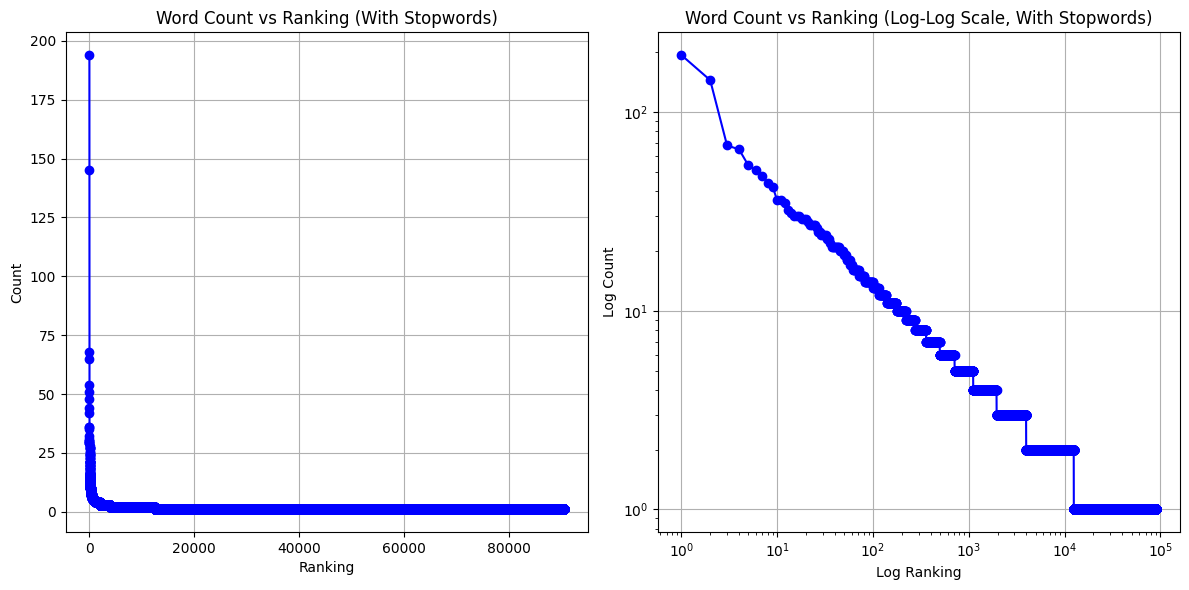

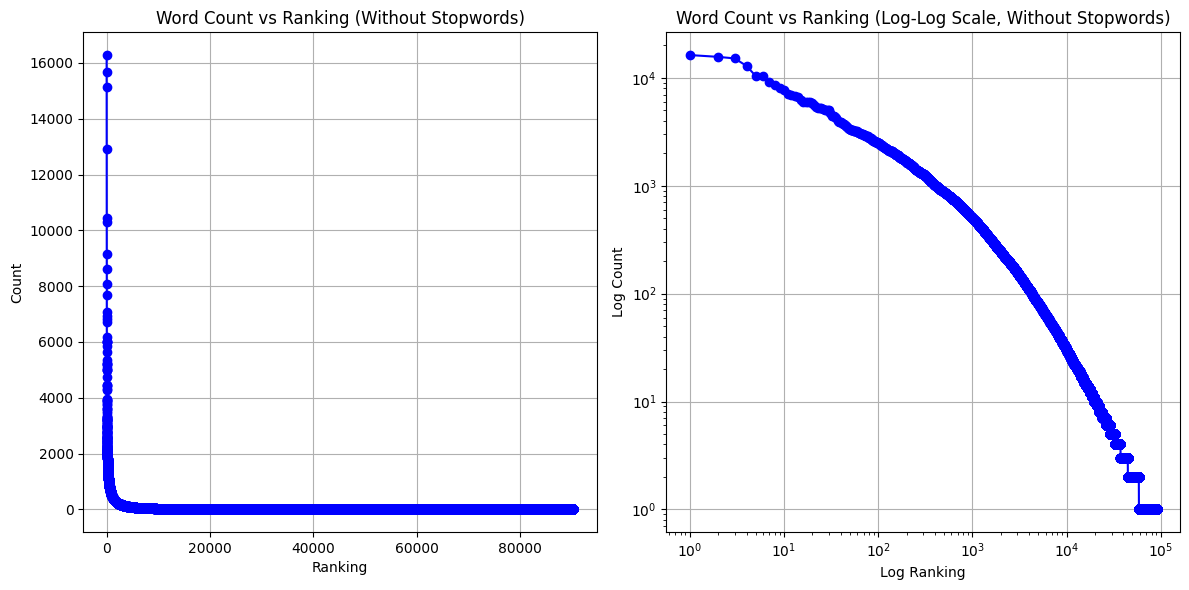

In [190]:
# Plot Count vs Ranking for df_sorted_with_stopwords
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico 1: Count vs Ranking
ax1.plot(df_sorted_with_stopwords['Ranking'], df_sorted_with_stopwords['Count'], marker='o', linestyle='-', color='b')
ax1.set_title('Word Count vs Ranking (With Stopwords)')
ax1.set_xlabel('Ranking')
ax1.set_ylabel('Count')
ax1.grid(True)

# Gráfico 2: Count vs Ranking (Log-Log Scale)
ax2.plot(df_sorted_with_stopwords['Ranking'], df_sorted_with_stopwords['Count'], marker='o', linestyle='-', color='b')
ax2.set_title('Word Count vs Ranking (Log-Log Scale, With Stopwords)')
ax2.set_xlabel('Log Ranking')
ax2.set_ylabel('Log Count')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Plot Count vs Ranking for df_sorted_without_stopwords
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico 1: Count vs Ranking
ax1.plot(df_sorted_without_stopwords['Ranking'], df_sorted_without_stopwords['Count'], marker='o', linestyle='-', color='b')
ax1.set_title('Word Count vs Ranking (Without Stopwords)')
ax1.set_xlabel('Ranking')
ax1.set_ylabel('Count')
ax1.grid(True)

# Gráfico 2: Count vs Ranking (Log-Log Scale)
ax2.plot(df_sorted_without_stopwords['Ranking'], df_sorted_without_stopwords['Count'], marker='o', linestyle='-', color='b')
ax2.set_title('Word Count vs Ranking (Log-Log Scale, Without Stopwords)')
ax2.set_xlabel('Log Ranking')
ax2.set_ylabel('Log Count')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Definición de leyes de Zipf

In [191]:
# Función de Zipf general
def zipf_function(rank, a, b, c):
    return a / (rank + b) ** c


In [192]:
# Computa los valores estimados según la ley de Zipf
def compute_zipf_estimated_values(ranks, a, b, c):
    return [zipf_function(rank, a, b, c) for rank in ranks]


In [193]:
# Encuentra los parámetros ajustados para la ley de Zipf
def find_curve_fit_values(function, xdata, ydata, initial_params, bounds):
    params, _ = curve_fit(function, xdata, ydata, p0=initial_params, bounds=bounds)
    return params


In [195]:
# Ajustes para curve_fit en la ley de Zipf
initial_params = [1, 0, 1]

bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])  # Esto asegura que b sea >= 0


# Ajustamos los parámetros usando la función find_curve_fit_values
params = find_curve_fit_values(zipf_function, rankings, freq, initial_params, bounds)

params_stopwords = find_curve_fit_values(zipf_function, rankings_stopwords, freq_stopwords, initial_params, bounds)

# Calculamos los valores estimados de la ley de Zipf
zipf_estimations = compute_zipf_estimated_values(rankings, *params)

zipf_estimations_stopwords = compute_zipf_estimated_values(rankings_stopwords, *params_stopwords)


### Visualización

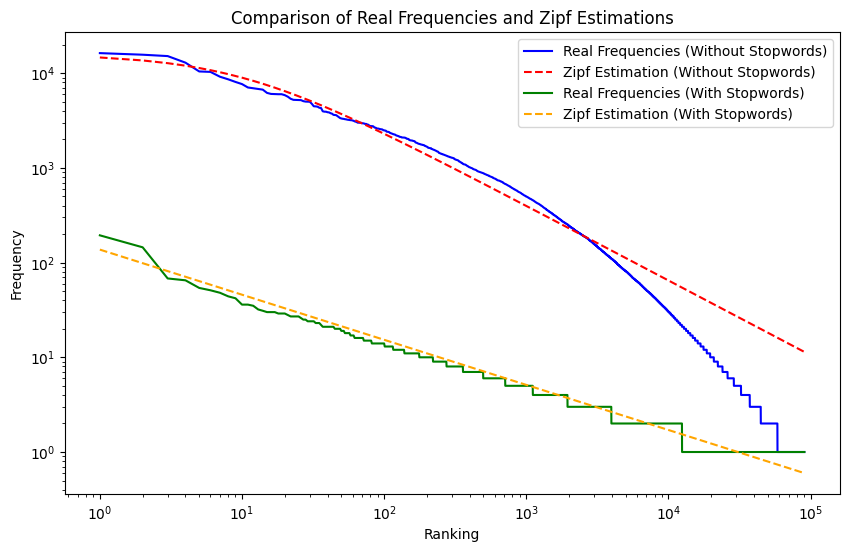

In [196]:
# Graficar los datos reales y las estimaciones
plt.figure(figsize=(10, 6))

# Gráfico de las frecuencias reales
plt.plot(rankings, freq, label='Real Frequencies (Without Stopwords)', color='blue')

# Gráfico de las estimaciones de la ley de Zipf
plt.plot(rankings, zipf_estimations, label='Zipf Estimation (Without Stopwords)', color='red', linestyle='--')

# Gráfico de las frecuencias reales con stopwords
plt.plot(rankings_stopwords, freq_stopwords, label='Real Frequencies (With Stopwords)', color='green')

# Gráfico de las estimaciones de la ley de Zipf con stopwords
plt.plot(rankings_stopwords, zipf_estimations_stopwords, label='Zipf Estimation (With Stopwords)', color='orange', linestyle='--')

plt.yscale('log')
plt.xscale('log')

# Etiquetas y título
plt.xlabel('Ranking')
plt.ylabel('Frequency')
plt.title('Comparison of Real Frequencies and Zipf Estimations')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()